# 1. Data overview

Let's form the first insight into the Yandex Music data

Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Load source of data (csv file)

In [2]:
df = pd.read_csv('yandex_music_project.csv')

Print 10 random rows of the table to get an overview of its structure

In [3]:
df.sample(10)

,userID,Track,artist,genre,City,time,Day
9459,F502D641,Польска криминальна,Глебати,rap,Moscow,08:03:54,Friday
3577,B1FE800D,The Red Carpet,The Alchemist,rap,Moscow,14:31:10,Monday
416,A85FE636,Utopia - Me Giorgio,NaN,dance,Moscow,20:10:27,Monday
36840,D67912E,Let Down,Dead By Sunrise,rock,Moscow,14:25:14,Monday
48021,EED05948,NaN,NaN,NaN,Moscow,08:26:48,Wednesday
45118,1E0AE19B,The Cheeky Munt,Chamberlain,electronic,Moscow,09:31:24,Friday
32827,598EE0FE,Into the Storm,Ocean Jet,local,Moscow,13:29:40,Friday
50156,E087C88A,When I Need You,NaN,jazz,Saint-Petersburg,21:37:35,Wednesday
26744,F44A418E,NaN,NaN,pop,Saint-Petersburg,20:09:51,Monday
21220,B3AEE0E,I Can Change,Robert G,rock,Moscow,21:16:37,Wednesday


Get general information about the data in the table

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0     userID  65079 non-null  object
 1   Track     63848 non-null  object
 2   artist    57876 non-null  object
 3   genre     63881 non-null  object
 4     City    65079 non-null  object
 5   time      65079 non-null  object
 6   Day       65079 non-null  object
dtypes: object(7)
memory usage: 3.5+ MB


### Section 1 conclusions

Each row of the table contains data about the track listened to. Part of the columns describes the song - title, artist and genre. The rest of the data tells about the users: what city they are from, when they listened to the music. 

Preliminarily, we can say that there is enough data to test hypotheses. But there are gaps in the data, and there are some inconsistencies in the column names.

To move forward, we need to fix the problems in the data.

# 2. Data preprocessing

First of all, let's print the column names on the screen

In [5]:
df.columns

Index(['  userID', 'Track', 'artist', 'genre', '  City  ', 'time', 'Day'], dtype='object')

Then rename the columns and bring them to a general standard

In [6]:
df = df.rename(columns={
    '  userID': 'user_id',
    'Track': 'track',
    '  City  ': 'city',
    'Day': 'day'
    })

Check columns' name changes

In [7]:
df.columns

Index(['user_id', 'track', 'artist', 'genre', 'city', 'time', 'day'], dtype='object')

Calculate how many missing values there are in the table

In [8]:
df.isna().sum()

user_id       0
track      1231
artist     7203
genre      1198
city          0
time          0
day           0
dtype: int64

Replace the missing values in the **track**, **artist** and **genre** columns with the string **'unknown'** (as there is no way to determine the cause of the missing values and correct them in this project)

In [9]:
columns_to_replace = ['track', 'artist', 'genre']

for column in columns_to_replace:
    df[column] = df[column].fillna('unknown')

Make sure that there are no gaps in the table. To do this, calculate the missing values again.

In [10]:
df.isna().sum()

user_id    0
track      0
artist     0
genre      0
city       0
time       0
day        0
dtype: int64

Let's first count the obvious duplicates in the table, then delete them and check the result of the removal operation

In [11]:
print(df.duplicated().sum())

df = df.drop_duplicates()

print(df.duplicated().sum())

3826
0


Next, eliminate any implicit duplicates in the **genre** column. For example, the name of the same genre may be written slightly differently. Such errors will also affect the result of the survey.

Let's start by displaying a list of unique genre titles sorted in alphabetical order

In [12]:
genre = df['genre']

genre = genre.sort_values()

genre.unique()

array(['acid', 'acoustic', 'action', 'adult', 'africa', 'afrikaans',
       'alternative', 'alternativepunk', 'ambient', 'americana',
       'animated', 'anime', 'arabesk', 'arabic', 'arena',
       'argentinetango', 'art', 'audiobook', 'author', 'avantgarde',
       'axé', 'baile', 'balkan', 'beats', 'bigroom', 'black', 'bluegrass',
       'blues', 'bollywood', 'bossa', 'brazilian', 'breakbeat', 'breaks',
       'broadway', 'cantautori', 'cantopop', 'canzone', 'caribbean',
       'caucasian', 'celtic', 'chamber', 'chanson', 'children', 'chill',
       'chinese', 'choral', 'christian', 'christmas', 'classical',
       'classicmetal', 'club', 'colombian', 'comedy', 'conjazz',
       'contemporary', 'country', 'cuban', 'dance', 'dancehall',
       'dancepop', 'dark', 'death', 'deep', 'deutschrock', 'deutschspr',
       'dirty', 'disco', 'dnb', 'documentary', 'downbeat', 'downtempo',
       'drum', 'dub', 'dubstep', 'eastern', 'easy', 'electronic',
       'electropop', 'emo', 'entehno', '

Go through the list and remove implicit duplicates of the hiphop name (hip, hop, hip-hop)

In [13]:
df['genre'] = df['genre'].replace(['hip', 'hop', 'hip-hop'], 'hiphop')

### Section 2 conclusions

Pre-processing found 3 problems in the data:

- irregularities in header style,
- missing values,
- duplicates, both explicit and implicit.

We have corrected the headings to make the table easier to work with. The study will be more accurate without duplicates.

You have replaced the missing values with 'unknown'.

Now we can move on to hypothesis testing. 

# 3. Hypothesis testing

### 3.1 Hypothesis #1: users listen to music differently in Moscow and St. Petersburg

Identify all the unique values of weekdays and cities in our data

In [14]:
weekdays = df['day'].unique()
cities = df['city'].unique()

print(weekdays)
print(cities)

['Wednesday' 'Friday' 'Monday']
['Saint-Petersburg' 'Moscow']


Set the "classic" order of weekdays

In [15]:
# Use the groupby method and aggregation (e.g., count()) to combine data
grouped = df.groupby(["day", "city"])["user_id"].count().unstack()

# Determine the desired order of the days of the week
desired_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Use the Categorical method to set the order of the days of the week
df["day"] = pd.Categorical(df["day"], categories=desired_order, ordered=True)

Build a plot to determine the number of listening by weekdays and cities

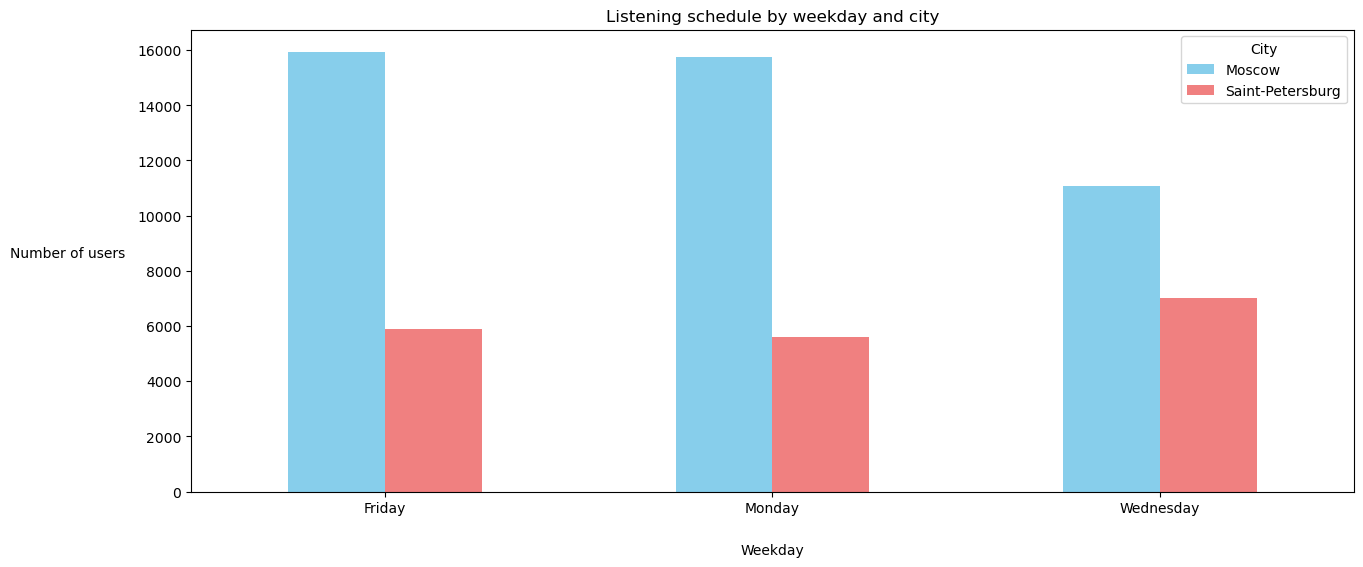

In [16]:
# Customize colors of plot bars
colors = ["skyblue", "lightcoral"]

# Create a chart object and customize it
ax = grouped.plot(kind="bar", stacked=False, color=colors, figsize=(15, 6))

# Add the plot and axes titles, and customize their location
plt.xlabel("Weekday", labelpad=20)
plt.ylabel("Number of users", rotation=0, labelpad=50)
plt.title("Listening schedule by weekday and city")

# Make the labels on the X-axis horizontal with a rotation angle of 0 degrees
plt.xticks(rotation=0)

# Add a legend
plt.legend(title="City", loc="upper right")

# Show the plot
plt.show()

### Hypothesis #1 conclusion:

The data reveals the difference in user behavior:

- In Moscow, listening peaks on Monday and Friday, with a noticeable decline on Wednesday.
- In St. Petersburg, on the contrary, more people listen to music on Wednesdays. The activity on Monday and Friday is less than on Wednesday.

So, the first hypothesis is true.

### 3.2 Hypothesis #2: different genres prevail on Monday morning and Friday evenings, depending on the city.
The morning range is between 6 am and 11 am, the evening range is between 5 pm and 11 pm

Create an auxiliary function with parameters:
- table (data frame) with data,
- day of the week,
- initial timestamp in the format 'hh:mm',
- last timestamp in the format 'hh:mm'.

The function should return information about the top 10 genres of the tracks listened to on the specified day, between the two timestamps.

In [17]:
def top_10_genre(df, city, day, time_min, time_max):
    # Sequential filtering
    
    # Keep in *genre_df* only rows with selected city    
    genre_df = df[df['city'] == city]

    # Keep in *genre_df* only rows with selected weekday    
    genre_df = genre_df[genre_df['day'] == day]
    
    # Keep in *genre_df* only rows with time less than or equal time_max
    genre_df = genre_df[genre_df['time'] <= time_max]
    
    # Keep in *genre_df* only rows with time greater than or equal time_min
    genre_df = genre_df[genre_df['time'] >= time_min]
    
    # Let's group the filtered dataframe by the column with genre titles. 
    # Take *genre* column and count the number of rows for each genre using the count() method
    genre_df_grouped = genre_df.groupby('genre')['genre'].count()
    
    # Sort the result in descending order (so that the most popular genres are at the top of the series)
    genre_df_sorted = genre_df_grouped.sort_values(ascending=False)
    
    # Return a Series with the top 10 most popular genres in the specified time period of a given day
    return genre_df_sorted[:10]

Create lists for processing graphs making in cycle

In [18]:
h2_inputs = [('Monday', '06:00', '11:00'), ('Friday', '17:00', '23:00')]

Compare the genre distribution graphs for Moscow and St. Petersburg on Monday morning (from 6 am to 11 am) and Friday evening (from 5 pm to 11 pm)

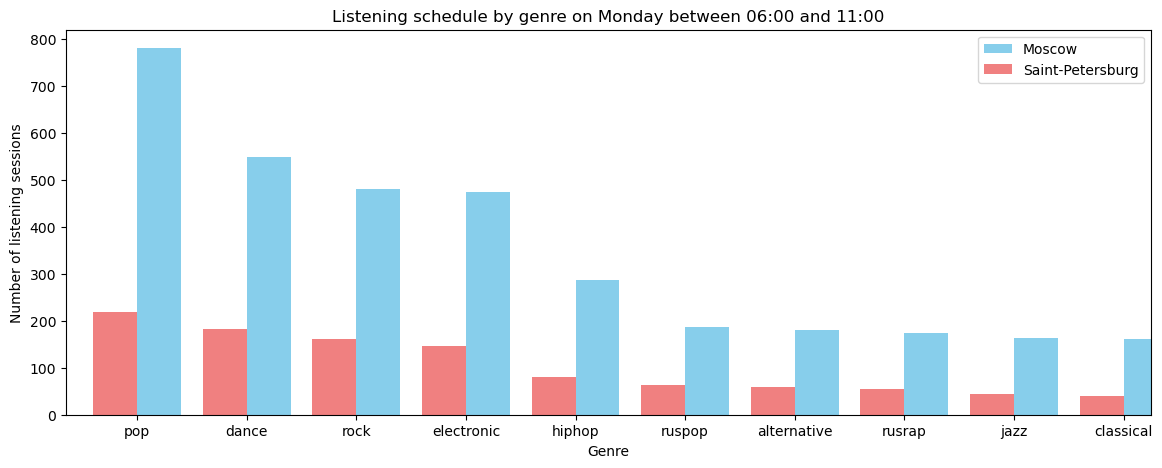

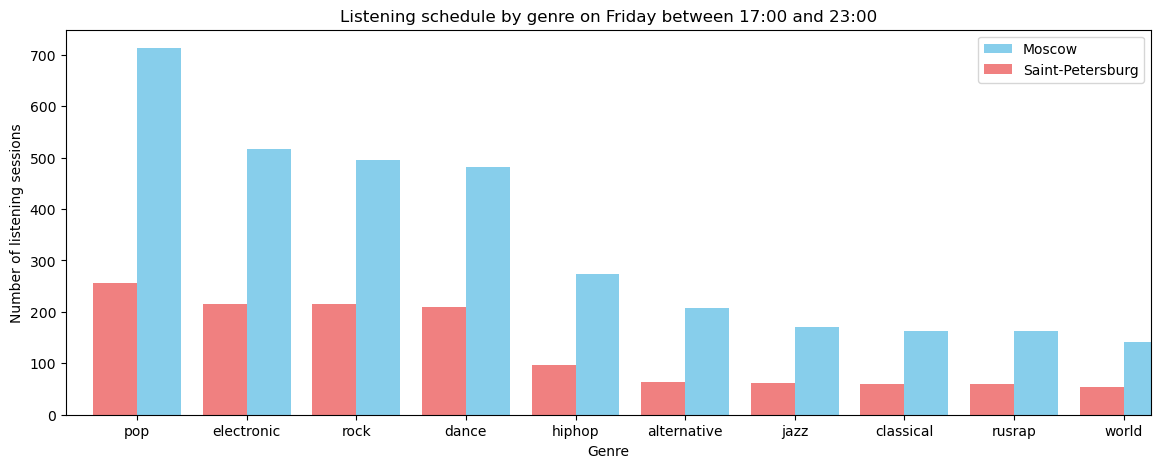

In [19]:
for item in h2_inputs:
    plt.figure(figsize=(14, 5))  # Customize the size of the chart
            
    ax = top_10_genre(df, "Moscow", item[0], item[1], item[2])\
                        .plot(kind="bar", color="skyblue", position=0, width=0.4, label="Moscow")
    
    top_10_genre(df, "Saint-Petersburg", item[0], item[1], item[2])\
                        .plot(kind="bar", color="lightcoral", position=1, width=0.4, label="Saint-Petersburg")
            
    # Configure the labels and the title
    plt.xlabel("Genre")
    plt.ylabel("Number of listening sessions")
    plt.title("Listening schedule by genre on " + item[0] + " between " + item[1] + " and " + item[2])
        
    # Make the labels on the X-axis horizontal with a rotation angle of 0 degrees
    plt.xticks(rotation=0)

    # Add a legend
    plt.legend()

    plt.show()

### Hypothesis #2 conclusion:

The second hypothesis was not confirmed.

Users listen to similar music at the beginning and at the end of the working week. The difference between Moscow and St. Petersburg is not significant.

### 3.3 Hypothesis #3a: St. Petersburg is the capital of rap music, and music of this genre is listened to there more often than in Moscow. #3b: Moscow is a city of contrasts, where pop music nevertheless prevails.

Group the source by genre and count the listens of tracks of each genre using the count() method for each city. Then sort the result in descending order

In [20]:
moscow_genres = df[df['city'] == "Moscow"].groupby('genre')['genre'].count().sort_values(ascending=False).head(10)

spb_genres = df[df['city'] == "Saint-Petersburg"].groupby('genre')['genre'].count().sort_values(ascending=False).head(10)

Create an auxiliary function to build the charts

In [21]:
def bar_chart_for_city(data, color, label, horizontal_lines=None):
    plt.figure(figsize=(14, 3))  # Customize the size of the chart
            
    data.plot(kind="bar", color=color, width=0.4, label=label)
            
    # Configure the labels and the title
    plt.xlabel("Genre")
    plt.ylabel("Number of listening sessions")
    plt.title("Listening sessions by genre")
        
    # Make the labels on the X-axis horizontal with a rotation angle of 0 degrees
    plt.xticks(rotation=0)
    
    # Add horizontal lines on background
    if horizontal_lines:
        for line in horizontal_lines:
            hline = plt.axhline(y=line, color='lightgray', linestyle='-', linewidth=0.4)
            hline.set_zorder(-1)
            
    # Add data labels to bars
    for index, value in enumerate(data):
        plt.text(index, value + 1, str(value), ha='center', va='bottom', fontsize=8, color='black')

    # Add a legend
    plt.legend()

    plt.show()

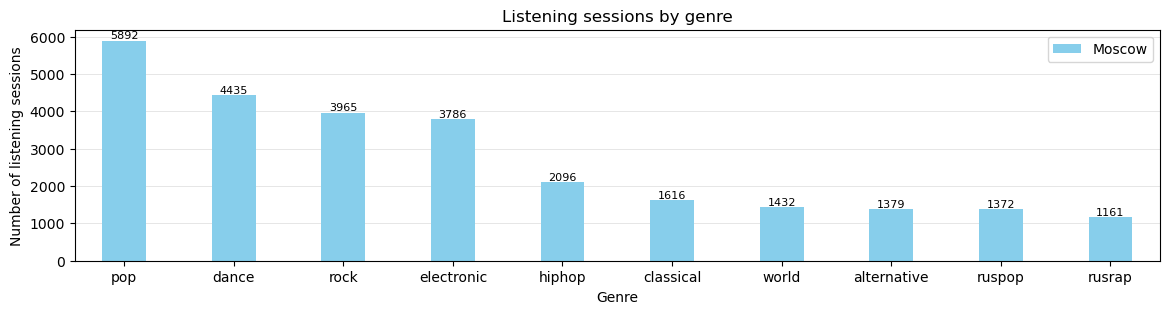

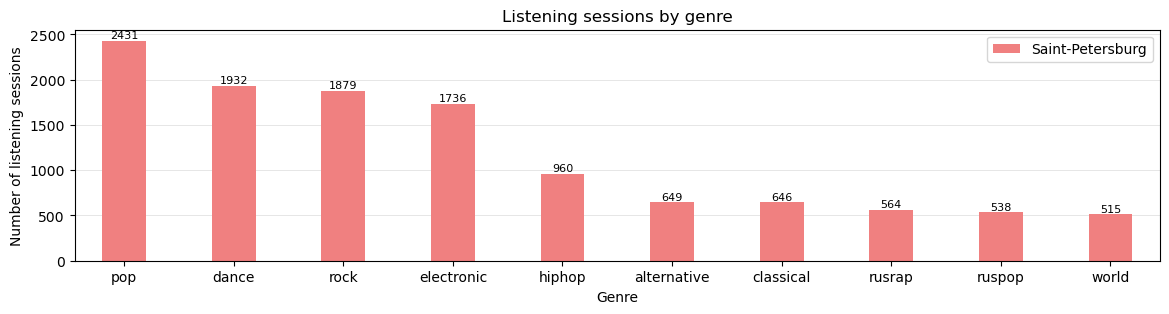

In [22]:
bar_chart_for_city(moscow_genres, "skyblue", "Moscow", [1000, 2000, 3000, 4000, 5000, 6000])

bar_chart_for_city(spb_genres, "lightcoral", "Saint-Petersburg", [500, 1000, 1500, 2000, 2500])

### Hypothesis #3 conclusion:

The hypothesis 3b was confirmed, 3a was not:

- Pop music is the most popular genre in Moscow, just as the hypothesis suggested. Moreover, there is a close genre in the top 10 genres - Russian popular music.
- Contrary to expectations, rap is equally popular in Moscow (10th) and St. Petersburg (8th).

# 4. Project outcomes

We have tested 3 hypotheses and found that:

- The day of the week has a different effect on user activity in Moscow and St. Petersburg. **The first hypothesis was confirmed.**

- Music preferences do not change much during the week, whether in Moscow or St. Petersburg. **The first hypothesis was not confirmed.**

- There are more common features than differences in the tastes of Moscow and St. Petersburg users. Contrary to expectations, genre preferences in St. Petersburg are similar to those in Moscow. **The hypothesis 3b was confirmed, 3a was not**.